<a href="https://colab.research.google.com/github/xdr100/5241HW/blob/main/HW4Q5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Modules

In [6]:
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
!dir

drive  sample_data


In [14]:
path='/content/drive/My Drive/5241Project/'

## Define Functions

In [47]:
def create_dataloader(x_path,y_path,batch_size=128,num_workers=0):
    '''
    Params:
    x_path: the path to the x file 
    y_path: the path to the y file
    '''
    #read the data from path
    x = pd.read_csv(x_path, sep = ' ',header = None)
    y = pd.read_csv(y_path, sep = ' ',header = None)
    #transform numpy array to tensor
    x_tensor = torch.Tensor(x.to_numpy().reshape(x.shape[0],x.shape[1])) #(n,784)
    y_tensor = torch.Tensor(y.to_numpy().reshape(y.shape[0],y.shape[1])) #(n,1)
    #float to int
    y_tensor = y_tensor.type(torch.LongTensor)
    #move the tensor to dataset and dataloader
    dataset = TensorDataset(x_tensor,y_tensor)
    dataloader = DataLoader(dataset,batch_size = batch_size,shuffle=True,num_workers = num_workers )
    return dataloader

## Dataframe to Torch Dataset
- !TODO explain why we need to use dataset  
- For the mini-batch gradient descent 

In [48]:
batch_size = 128
num_workers = 0 
#load the dataset
train_loader = create_dataloader(x_path=path+'train_x.txt',y_path=path+'train_y.txt',
                                 batch_size=batch_size,num_workers=num_workers)
valid_loader = create_dataloader(x_path=path+'test_x.txt',y_path=path+'test_y.txt',
                                 batch_size=batch_size,num_workers=num_workers)
# check if CUDA is available
use_cuda = torch.cuda.is_available()
#create a dictionary of dataset_loader
data_loaders = {'train':train_loader,'test':valid_loader}

In [16]:
use_cuda

True

## Model Architecture

In [49]:
def init_model(model_input=784,hidden_out=100,model_out=10):
    fc_model = nn.Sequential(
        nn.Linear(model_input,hidden_out),
        nn.ReLU(),
        nn.Linear(hidden_out,model_out))
    return fc_model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, tol= 0.001, print_log = False,stop_train=False):
    '''
    Params:
        n_epoch: how many epochs of training
        loaders: the training & testing dataloads
        optimizer: optimizer used in the training process
        model: PyTorch model defined previously
        criterion: compute a gradient according to a given loss function
        use_cuda: if use cuda is true, train in GPU
        tol: the minimum different that keep the training 
        print_log: whether to print the training process or not
        stop_train: whether stop training when there's overfitting
    
    '''
    # initialize tracker for train/validation loss
    losses = {'train':[], 'validation':[]}
    accuracy = {'train':[],'validation':[]}
    valid_loss_min = np.Inf
    if use_cuda:
        model.cuda()
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0
        train_total = 0
        valid_correct = 0
        valid_total = 0
        
        ###################
        # train the model #
        ###################
        model.train() #dim of data (128,784) target(128,1,1)
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            #clean up the gradient   
            optimizer.zero_grad()
            #find the prediciton
            output = model(data) 
            #compute the loss
            loss = criterion(output,target.squeeze())
            #backpropagation
            loss.backward()
            #perform gradient update 
            optimizer.step() 
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss)) 
            # convert output probabilities to predicted class
            pred_label = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred_label.eq(target.data.view_as(pred_label))).cpu().numpy())
            train_total += data.size(0)
        #store the training loss
        losses['train'].append(train_loss)
        accuracy['train'].append(train_correct/train_total)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## compute the output from the model
            output = model(data)
            #compute loss
            loss = criterion(output,target.squeeze())
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            # convert output probabilities to predicted class
            pred_label = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred_label.eq(target.data.view_as(pred_label))).cpu().numpy())
            valid_total += data.size(0)
        losses['validation'].append(valid_loss)
        accuracy['validation'].append(valid_correct/valid_total)
        #if the different between validation error is small, then stop the training process
        #print the parameter used in the training process 
        if stop_train:
            if valid_loss <= valid_loss_min:
                #model performance is not improving anymore
                #break the loop and print the current parameter used
                #print(f'Valid Loss Diff: {valid_loss_min - valid_loss}')
                if valid_loss_min - valid_loss <= tol:
                    break
                valid_loss_min = valid_loss
        # print training/validation statistics for every 10 epochs    
        if print_log:
            if epoch%10 ==0:
                print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, train_loss, valid_loss))
                print(f'Training Accuracy: {100.*train_correct/train_total:.2f} \t Validation Accuracy:{100.*valid_correct/valid_total:.2f}')
    print(f'Training used {epoch} epochs')
    return model, losses, accuracy

## Different model performances

Epoch: 10 	Training Loss: 0.263723 	Validation Loss: 0.221083
Training Accuracy: 92.41 	 Validation Accuracy:93.85
Epoch: 20 	Training Loss: 0.179652 	Validation Loss: 0.183651
Training Accuracy: 94.65 	 Validation Accuracy:94.25
Epoch: 30 	Training Loss: 0.127392 	Validation Loss: 0.176066
Training Accuracy: 96.55 	 Validation Accuracy:94.80
Epoch: 40 	Training Loss: 0.092824 	Validation Loss: 0.167745
Training Accuracy: 97.69 	 Validation Accuracy:95.00
Epoch: 50 	Training Loss: 0.067297 	Validation Loss: 0.158746
Training Accuracy: 98.61 	 Validation Accuracy:95.40
Epoch: 60 	Training Loss: 0.051159 	Validation Loss: 0.161869
Training Accuracy: 99.04 	 Validation Accuracy:95.50
Epoch: 70 	Training Loss: 0.037757 	Validation Loss: 0.163751
Training Accuracy: 99.45 	 Validation Accuracy:95.25
Epoch: 80 	Training Loss: 0.029266 	Validation Loss: 0.158983
Training Accuracy: 99.70 	 Validation Accuracy:95.60
Epoch: 90 	Training Loss: 0.023225 	Validation Loss: 0.162139
Training Accuracy:

Text(0, 0.5, 'loss')

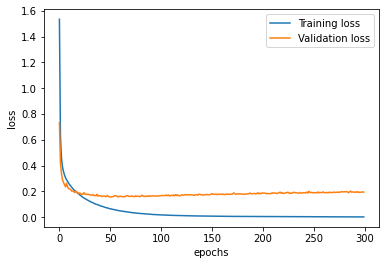

In [50]:
epochs = 300
torch.manual_seed(seed)
#initial the model
model = init_model()
#define the criterion
criterion = nn.CrossEntropyLoss()
#initial the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)
#training process
retrained_model, losses, _ = train(epochs,data_loaders,model,optimizer,criterion,use_cuda,print_log=True)
#321 indicate 3 rows 2 columns 
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')


As illustrated above, the training process starts converging and being overfitting after 150 epochs.

Epoch: 10 	Training Loss: 0.265774 	Validation Loss: 0.233456
Training Accuracy: 92.36 	 Validation Accuracy:93.15
Epoch: 20 	Training Loss: 0.176508 	Validation Loss: 0.203686
Training Accuracy: 94.95 	 Validation Accuracy:94.00
Epoch: 30 	Training Loss: 0.124853 	Validation Loss: 0.177253
Training Accuracy: 96.56 	 Validation Accuracy:94.60
Epoch: 40 	Training Loss: 0.088928 	Validation Loss: 0.170421
Training Accuracy: 97.88 	 Validation Accuracy:94.95
Epoch: 50 	Training Loss: 0.064342 	Validation Loss: 0.162120
Training Accuracy: 98.67 	 Validation Accuracy:95.40
Epoch: 60 	Training Loss: 0.047790 	Validation Loss: 0.161826
Training Accuracy: 99.14 	 Validation Accuracy:95.20
Epoch: 70 	Training Loss: 0.036098 	Validation Loss: 0.162088
Training Accuracy: 99.51 	 Validation Accuracy:95.60
Epoch: 80 	Training Loss: 0.028069 	Validation Loss: 0.164637
Training Accuracy: 99.67 	 Validation Accuracy:95.25
Epoch: 90 	Training Loss: 0.021864 	Validation Loss: 0.165074
Training Accuracy:

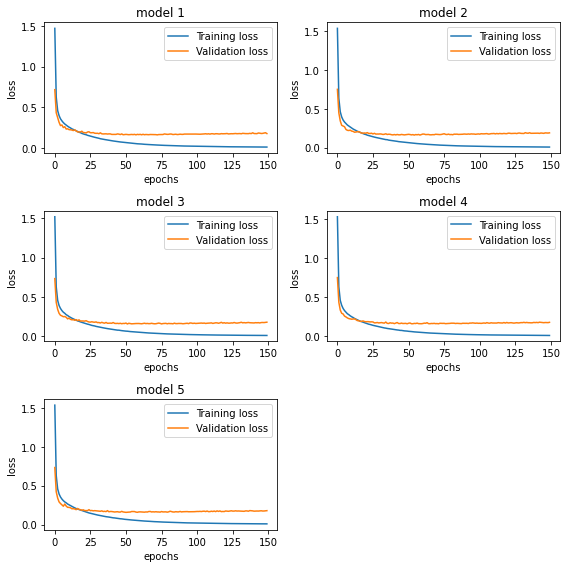

In [20]:
epochs = 150
#generate fixed seed for different models
generated_seed = [random.randrange(0,2021) for _ in range(5)]
#learning rate 
lr = 0.1
#set the seed for training class
plt.figure(figsize=(8,8))
for idx, seed in enumerate(generated_seed):
    torch.manual_seed(seed)
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)
    #training process
    retrained_model, losses, _ = train(epochs,data_loaders,model,optimizer,criterion,use_cuda,print_log=True)
    #321 indicate 3 rows 2 columns 
    plt.subplot(321+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(f'model {idx+1}')
plt.tight_layout()

The performanc is generally better in the training dataset than in the validation dataset, and after about 25 epochs, the performance is still increased on the training dataset, while the perfroamce is getting worse on the validation dataset.

## Part B

Training used 150 epochs


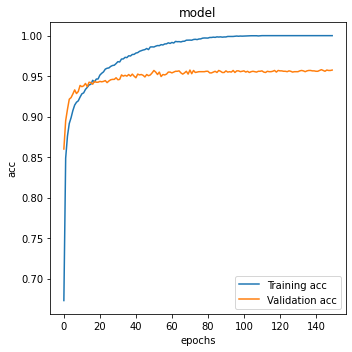

In [51]:
epochs = 150
#learning rate 
lr = 0.1
#set the seed for training class
plt.figure(figsize=(5,5))
torch.manual_seed(seed)
#initial the model
model = init_model()
#define the criterion
criterion = nn.CrossEntropyLoss()
#initial the optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)
#training process
retrained_model, losses, accuracy = train(epochs,data_loaders,model,optimizer,criterion,use_cuda,print_log=False)
plt.plot(accuracy['train'], label='Training acc')
plt.plot(accuracy['validation'], label='Validation acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title(f'model')
plt.tight_layout()

The training accuracy keeps growing to 1.0, and the validation accuracy stop increasing after about 60 epochs. Compared with the plot of cross-entropy loss, it seems that the performance on the validation dataset is not getting worse with more training epochs and just keep stable instead. 

## Part C

This question asked us to plot 100 images, but here for simplicity, I only plot 50 of them. And the features are 28x28 pixels.

In [115]:
import matplotlib.gridspec as gridspec

In [74]:
if use_cuda:
    retrained_model.cuda()

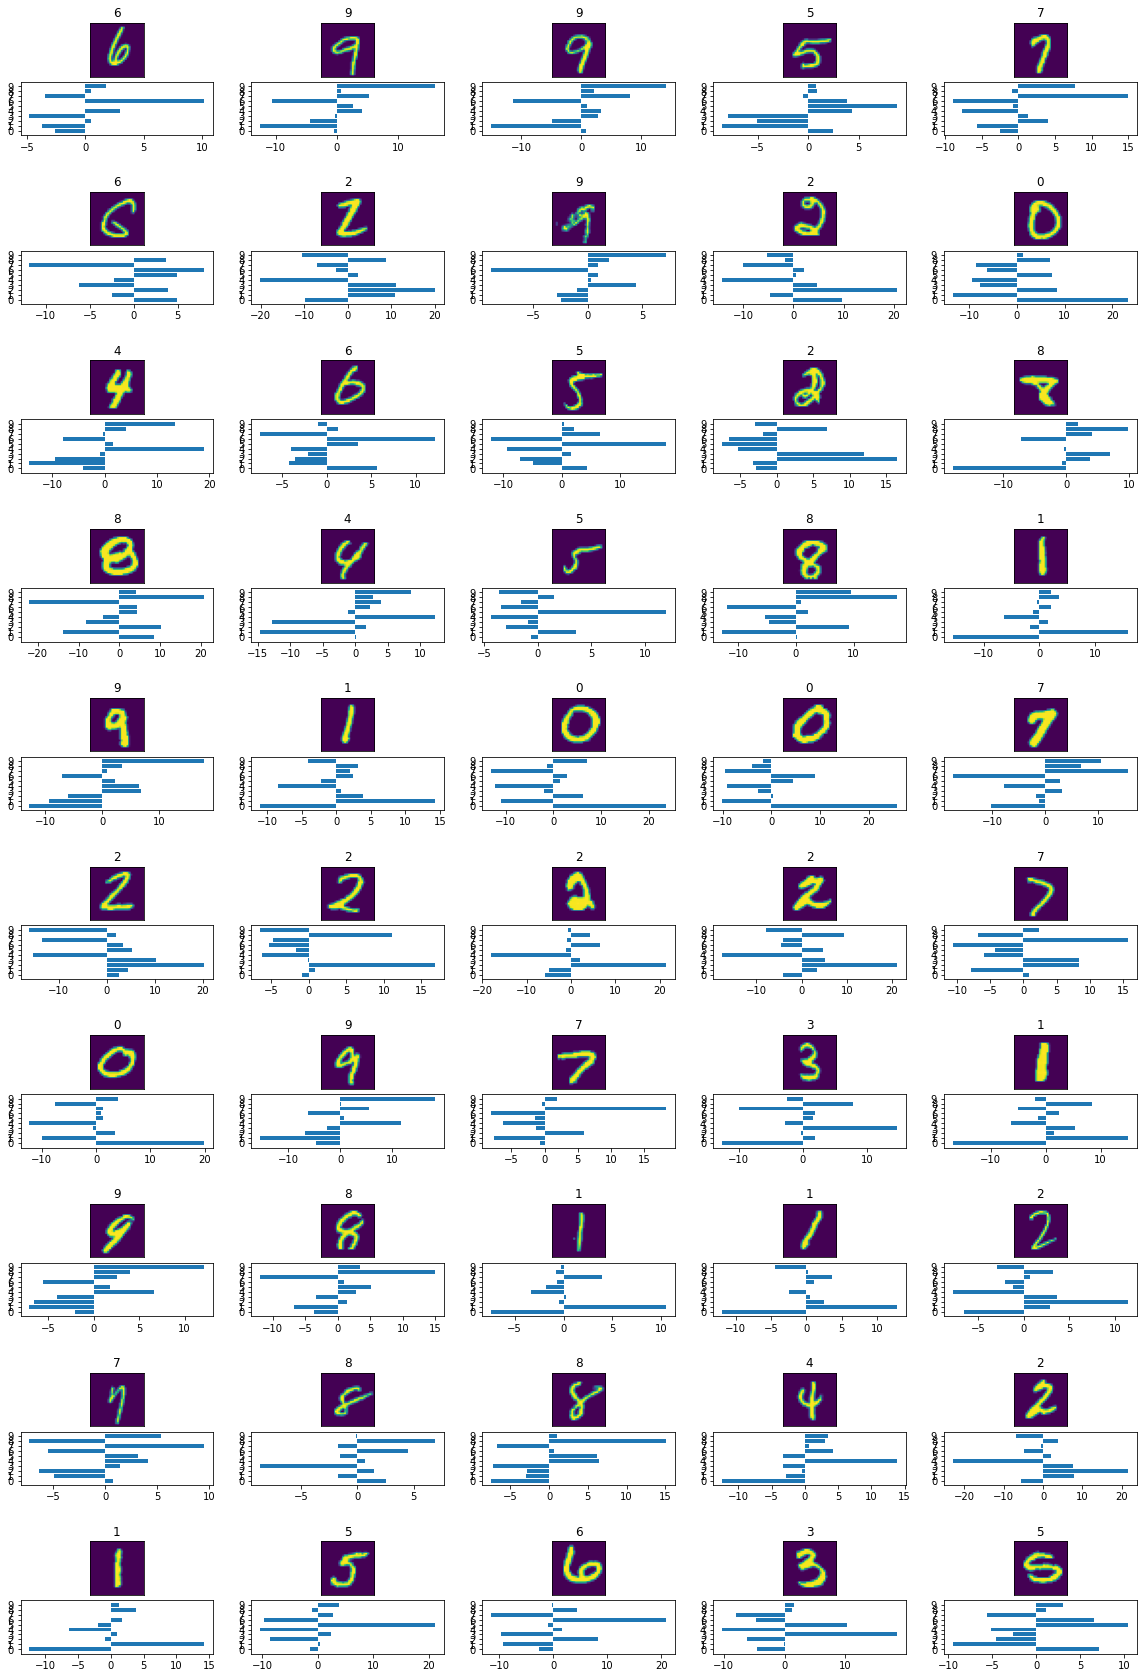

In [136]:
classes = ["0","1","2","3","4","5","6","7","8","9"]
fig = plt.figure(figsize=(20, 30))
outer = gridspec.GridSpec(10, 5, wspace=0.2, hspace=0.5)
for i, (images,labels) in enumerate(train_loader):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                      subplot_spec=outer[i], wspace=0.1, hspace=0.1)

    
    ax = plt.Subplot(fig, inner[0])
    ax.imshow(np.transpose(images[i].reshape(28,28)/2+0.5,(0,1) ))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(classes[labels[i]])
    fig.add_subplot(ax)
    ax = plt.Subplot(fig, inner[1])
    ax.barh(classes,retrained_model(images[i].cuda()).detach().cpu().numpy())
    fig.add_subplot(ax)
    #fig.tight_layout()
    if i>=49:
      break
#fig.tight_layout()

## Part D
 - Try different learning rate [0.1, 0.01, 0.2, 0.5]
 - Try different momentum [0.0,0.5,0.9]
 - Keep a track of how many epochs need to train so that no improvement

In [22]:
#set the training epochs 
n_epochs = 150
for lr in [0.1,0.01,0.2,0.5]:
    for moment in [0,0.5,0.9]:
        print('\nInitial Parameters:\t')
        print(f'lr: {lr}\t momentum: {moment} \n')
        #initial the model
        model = init_model()
        #define the criterion
        criterion = nn.CrossEntropyLoss()
        #initial the optimizer
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
        #training process
        retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

        


Initial Parameters:	
lr: 0.1	 momentum: 0 

Training used 7 epochs

Initial Parameters:	
lr: 0.1	 momentum: 0.5 

Training used 7 epochs

Initial Parameters:	
lr: 0.1	 momentum: 0.9 

Training used 3 epochs

Initial Parameters:	
lr: 0.01	 momentum: 0 

Training used 25 epochs

Initial Parameters:	
lr: 0.01	 momentum: 0.5 

Training used 16 epochs

Initial Parameters:	
lr: 0.01	 momentum: 0.9 

Training used 8 epochs

Initial Parameters:	
lr: 0.2	 momentum: 0 

Training used 3 epochs

Initial Parameters:	
lr: 0.2	 momentum: 0.5 

Training used 5 epochs

Initial Parameters:	
lr: 0.2	 momentum: 0.9 

Training used 5 epochs

Initial Parameters:	
lr: 0.5	 momentum: 0 

Training used 7 epochs

Initial Parameters:	
lr: 0.5	 momentum: 0.5 

Training used 7 epochs

Initial Parameters:	
lr: 0.5	 momentum: 0.9 

Training used 150 epochs


Training used 7 epochs
Training used 8 epochs
Training used 5 epochs


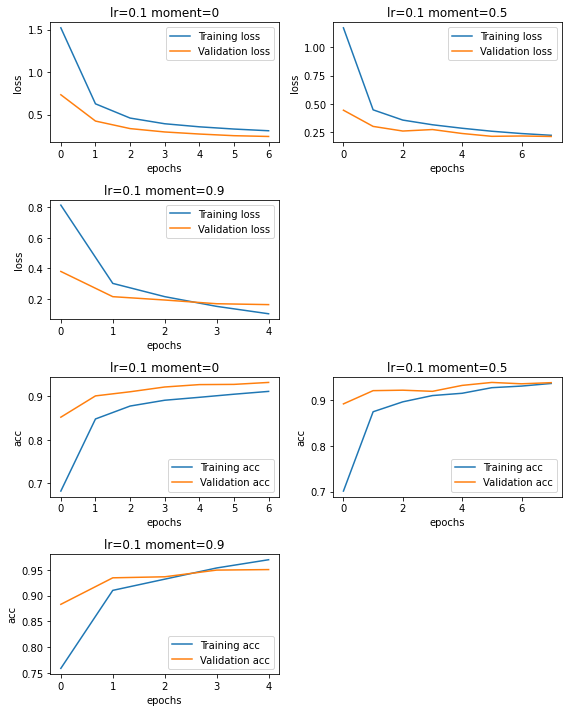

In [31]:
#set the training epochs 
n_epochs = 150
lr =0.1 #0.01,0.2,0.5
plt.figure(figsize=(8,10))

for idx,moment in enumerate([0,0.5,0.9]):
    #print('\nInitial Parameters:\t')
    #print(f'lr: {lr}\t momentum: {moment} \n')
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
    #training process
    retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

    plt.subplot(421+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("lr={} moment={}".format(lr,moment))

    plt.subplot(421+idx+4)
    plt.plot(accuracy['train'], label='Training acc')
    plt.plot(accuracy['validation'], label='Validation acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("lr={} moment={}".format(lr,moment))

plt.tight_layout()

Training used 24 epochs
Training used 17 epochs
Training used 10 epochs


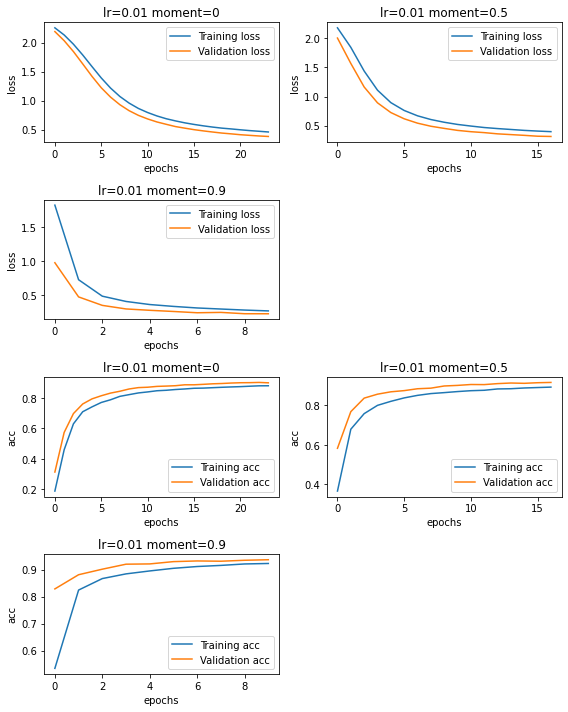

In [32]:
#set the training epochs 
n_epochs = 150
lr =0.01 #,0.2,0.5
plt.figure(figsize=(8,10))

for idx,moment in enumerate([0,0.5,0.9]):
    #print('\nInitial Parameters:\t')
    #print(f'lr: {lr}\t momentum: {moment} \n')
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
    #training process
    retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

    plt.subplot(421+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("lr={} moment={}".format(lr,moment))

    plt.subplot(421+idx+4)
    plt.plot(accuracy['train'], label='Training acc')
    plt.plot(accuracy['validation'], label='Validation acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("lr={} moment={}".format(lr,moment))

plt.tight_layout()

Training used 10 epochs
Training used 8 epochs
Training used 7 epochs


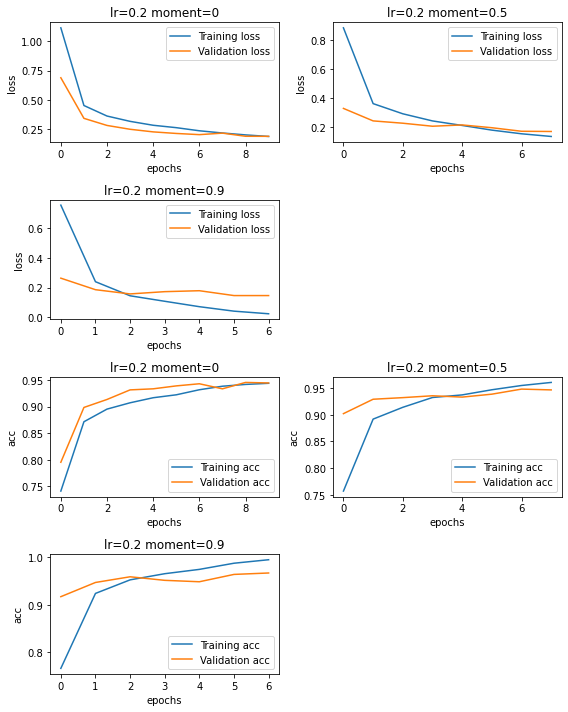

In [33]:
#set the training epochs 
n_epochs = 150
lr =0.2#,0.5
plt.figure(figsize=(8,10))

for idx,moment in enumerate([0,0.5,0.9]):
    #print('\nInitial Parameters:\t')
    #print(f'lr: {lr}\t momentum: {moment} \n')
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
    #training process
    retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

    plt.subplot(421+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("lr={} moment={}".format(lr,moment))

    plt.subplot(421+idx+4)
    plt.plot(accuracy['train'], label='Training acc')
    plt.plot(accuracy['validation'], label='Validation acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("lr={} moment={}".format(lr,moment))

plt.tight_layout()

Training used 8 epochs
Training used 3 epochs
Training used 150 epochs


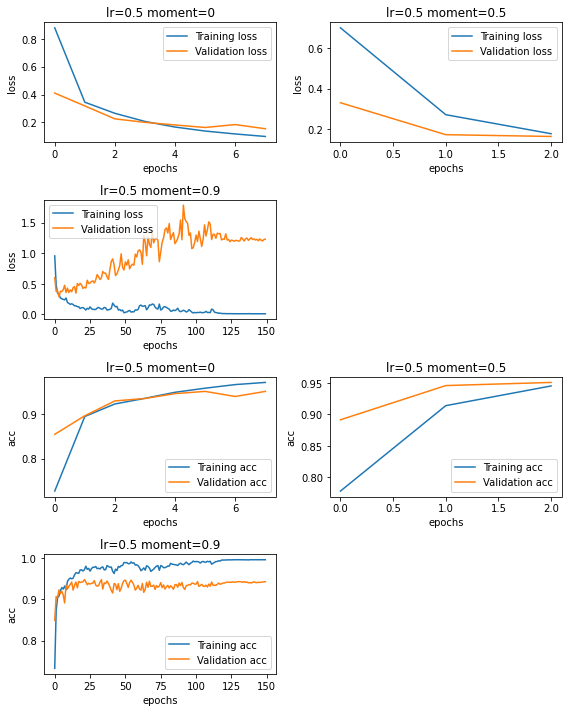

In [34]:
#set the training epochs 
n_epochs = 150
lr =0.5
plt.figure(figsize=(8,10))

for idx,moment in enumerate([0,0.5,0.9]):
    #print('\nInitial Parameters:\t')
    #print(f'lr: {lr}\t momentum: {moment} \n')
    #initial the model
    model = init_model()
    #define the criterion
    criterion = nn.CrossEntropyLoss()
    #initial the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=moment)
    #training process
    retrained_model, losses, accuracy = train(n_epochs,data_loaders,model,optimizer,criterion,use_cuda,tol= 0.01,print_log=False,stop_train = True)

    plt.subplot(421+idx)
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title("lr={} moment={}".format(lr,moment))

    plt.subplot(421+idx+4)
    plt.plot(accuracy['train'], label='Training acc')
    plt.plot(accuracy['validation'], label='Validation acc')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title("lr={} moment={}".format(lr,moment))

plt.tight_layout()

Epoch: 10 	Training Loss: 0.027396 	Validation Loss: 0.176731
Training Accuracy: 99.40 	 Validation Accuracy:95.00
Epoch: 20 	Training Loss: 0.004137 	Validation Loss: 0.154757
Training Accuracy: 100.00 	 Validation Accuracy:96.25
Epoch: 30 	Training Loss: 0.002185 	Validation Loss: 0.168347
Training Accuracy: 100.00 	 Validation Accuracy:96.15
Training used 30 epochs


Text(0.5, 1.0, 'lr=0.5 moment=0.9')

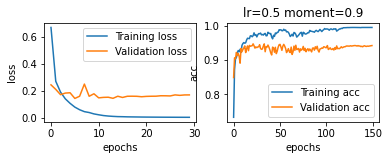

In [35]:
epochs = 30
torch.manual_seed(seed)
#initial the model
model = init_model()
#define the criterion
criterion = nn.CrossEntropyLoss()
#initial the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.5,momentum=0.5)
#training process
retrained_model, losses, _ = train(epochs,data_loaders,model,optimizer,criterion,use_cuda,print_log=True)
plt.subplot(221)
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.subplot(222)
plt.plot(accuracy['train'], label='Training acc')
plt.plot(accuracy['validation'], label='Validation acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title("lr={} moment={}".format(lr,moment))

Result: 
   - if the lr(0.01) is small, using momentum can decrease the training epochs dramatically, and it appears that for small lr, large momentum is better than small momentum;
   - if the lr is too big, as the momentum is bigger it might not able to converge. (when lr=0.5, the momentum of 0.9 is much worse than the momentum of 0.5);
   - Basically, the choice of these parameters relies on the trial-and-error or cross-validation; The lr of 0.5 and the momentum of 0.5 results in the fastest convergence at the current stage;

## E (cnn)

In [38]:
# define the CNN architecture
class Net(nn.Module):
    ### choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # Define layers of a CNN
        #input 1*28*28 -> 8*28*28 
        self.conv1_1 = nn.Conv2d(1,8,kernel_size= 3,stride=1,padding=1)
        # 8*28*28  -> 8*14*14
        self.maxpool1 = nn.MaxPool2d(2,2)
        #fully connected layer, padding
        self.fc1 = nn.Linear(8*14*14,100)
        #final layer output
        self.fc2 = nn.Linear(100,10)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = self.maxpool1(x)
        #flatten the shape 
        x = x.view(x.size(0),-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [39]:
# instantiate the CNN
model_cnn = Net()


In [40]:
def prepare_img_data(x_path,y_path,batch_size=128,num_workers=0):
    #read the data from path
    x = pd.read_csv(x_path, sep = ' ',header = None)
    y = pd.read_csv(y_path, sep = ' ',header = None)
    #transform numpy array to tensor
    x_tensor = torch.Tensor(x.to_numpy().reshape(x.shape[0],1,28,28))
    y_tensor = torch.Tensor(y.to_numpy().reshape(y.shape[0],y.shape[1]))
    #float to int
    y_tensor = y_tensor.type(torch.LongTensor)
    #move the tensor to dataset and dataloader
    dataset = TensorDataset(x_tensor,y_tensor)
    dataloader = DataLoader(dataset,batch_size = batch_size,shuffle=True,num_workers = num_workers)
    return dataloader

In [41]:
train_dataloader = prepare_img_data(x_path = path+'train_x.txt', y_path=path+'train_y.txt')
test_dataloader = prepare_img_data(x_path = path+'test_x.txt', y_path=path+'test_y.txt')
#create a dictionary of dataset_loader
data_loaders = {'train':train_dataloader,'test':test_dataloader}

Epoch: 10 	Training Loss: 0.039276 	Validation Loss: 0.102372
Training Accuracy: 98.65 	 Validation Accuracy:97.45
Epoch: 20 	Training Loss: 0.026113 	Validation Loss: 0.159648
Training Accuracy: 99.16 	 Validation Accuracy:97.10
Epoch: 30 	Training Loss: 0.022699 	Validation Loss: 0.161804
Training Accuracy: 99.29 	 Validation Accuracy:97.30
Epoch: 40 	Training Loss: 0.013222 	Validation Loss: 0.159129
Training Accuracy: 99.64 	 Validation Accuracy:97.70
Epoch: 50 	Training Loss: 0.018617 	Validation Loss: 0.149538
Training Accuracy: 99.47 	 Validation Accuracy:97.80
Training used 50 epochs


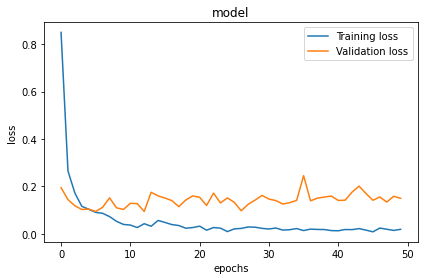

In [42]:
#define the criterion
criterion = nn.CrossEntropyLoss()
#initial the optimizer
optimizer = optim.SGD(model_cnn.parameters(), lr = 0.2, momentum = 0.9)
#training process
retrained_model, losses, accuracy = train(50,data_loaders,model_cnn,optimizer,criterion,use_cuda,print_log=True,stop_train=True)
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(f'model')
plt.tight_layout()

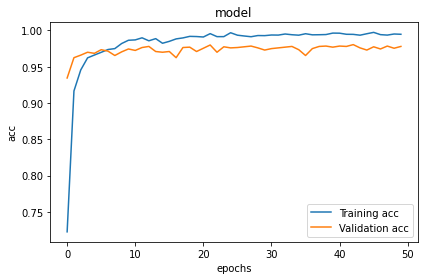

In [43]:
plt.plot(accuracy['train'], label='Training acc')
plt.plot(accuracy['validation'], label='Validation acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('acc')
plt.title(f'model')
plt.tight_layout()

Compared with the single layer network, this CNN performs a bit worse on the training dataset, but performs better on the validation dataset, in terms of loss and accuracy;